In [2]:
from torch.utils import data as data

import h5py
# local modules
from basicsr.data.h5_augment import *


import os

def transform_voxel(voxel, transpose_to_CHW=False, norm_voxel = True):
    """
    Augment voxel and turn into tensor
    @param voxel Input voxel
    @param seed  Seed for random number generation
    @returns Augmented voxel
    """

    if transpose_to_CHW:
        voxel = torch.from_numpy(voxel.transpose(2, 0, 1)).float()# H,W,C -> C,H,W

    else:
        if norm_voxel:
            voxel = torch.from_numpy(voxel).float() / abs(max(voxel.min(), voxel.max(), key=abs))  # -1 ~ 1
        else:
            voxel = torch.from_numpy(voxel).float()

    # if self.vox_transform:
    #     random.seed(seed)
    #     voxel = self.vox_transform(voxel)
    return voxel


import numpy as np

def discretize_values_bidirectional(values, peaks):
    """
    values: ND numpy array of real values (예: shape = (6, H, W))
    peaks:  1D array of 구간 경계 (예: [-1, -0.5, 0, 0.5, 1]), 오름차순 정렬 가정

    규칙:
      - x < 0  => 구간의 '상위 경계값'으로 매핑 (값을 올림)
      - x >= 0 => 구간의 '하위 경계값'으로 매핑 (값을 내림)
    """
    # 결과를 담을 배열(동일 shape) 초기화
    mapped_values = np.zeros_like(values, dtype=float)

    # 음수/양수 마스크
    neg_mask = (values < 0)
    pos_mask = (values >= 0)

    # -------------------------------
    # (A) 음수 영역: 상위 경계로 매핑
    def map_to_upper(vals_neg, boundary):
        """
        vals_neg: 1D or ND array (음수 부분만 슬라이싱)
        boundary: 1D array (peaks)
        """
        # 1) boundary[0]보다 작으면 boundary[0], boundary[-1]보다 크면 boundary[-1]로 클램핑
        vals_left_clamped = np.where(vals_neg < boundary[0], boundary[0], vals_neg)
        vals_clamped = np.where(vals_left_clamped >= boundary[-1], boundary[-1], vals_left_clamped)

        # 2) 구간 인덱스 찾기
        indices = np.searchsorted(boundary, vals_clamped, side='right') - 1
        # 3) valid range로 클램핑
        indices = np.clip(indices, 0, len(boundary) - 2)

        # 4) 상위 경계값
        return boundary[indices + 1]

    # -------------------------------
    # (B) 양수 영역: 하위 경계로 매핑
    def map_to_lower(vals_pos, boundary):
        """
        vals_pos: 1D or ND array (양수 부분만 슬라이싱)
        boundary: 1D array (peaks)
        """
        # 1) 클램핑
        vals_left_clamped = np.where(vals_pos < boundary[0], boundary[0], vals_pos)
        vals_clamped = np.where(vals_left_clamped >= boundary[-1], boundary[-1], vals_left_clamped)

        # 2) 구간 인덱스 찾기
        indices = np.searchsorted(boundary, vals_clamped, side='right') - 1
        indices = np.clip(indices, 0, len(boundary) - 2)

        # 3) 하위 경계값
        return boundary[indices]

    # 음수/양수 부분 각각 매핑 후, 결과에 반영
    mapped_values[neg_mask] = map_to_upper(values[neg_mask], peaks)
    mapped_values[pos_mask] = map_to_lower(values[pos_mask], peaks)

    return mapped_values


x_peak = np.array([-0.949     , -0.941     , -0.93700004, -0.899     , -0.895     ,
       -0.889     , -0.883     , -0.875     , -0.849     , -0.843     ,
       -0.833     , -0.823     , -0.81299996, -0.799     , -0.78900003,
       -0.777     , -0.765     , -0.749     , -0.737     , -0.73300004,
       -0.723     , -0.705     , -0.699     , -0.685     , -0.667     ,
       -0.649     , -0.643     , -0.63100004, -0.625     , -0.611     ,
       -0.599     , -0.589     , -0.579     , -0.571     , -0.56299996,
       -0.555     , -0.549     , -0.533     , -0.527     , -0.499     ,
       -0.491     , -0.487     , -0.481     , -0.473     , -0.467     ,
       -0.463     , -0.45499998, -0.449     , -0.445     , -0.43699998,
       -0.42900002, -0.421     , -0.411     , -0.399     , -0.389     ,
       -0.385     , -0.375     , -0.36900002, -0.357     , -0.353     ,
       -0.34899998, -0.333     , -0.329     , -0.315     , -0.29900002,
       -0.29500002, -0.28500003, -0.277     , -0.26700002, -0.263     ,
       -0.249     , -0.235     , -0.223     , -0.215     , -0.211     ,
       -0.199     , -0.187     , -0.177     , -0.167     , -0.157     ,
       -0.149     , -0.133     , -0.125     , -0.117     , -0.111     ,
       -0.105     , -0.099     , -0.067     , -0.063     , -0.059     ,
       -0.053     , -0.049     ,  0.001     ,  0.051     ,  0.059     ,
        0.063     ,  0.067     ,  0.07099999,  0.101     ,  0.105     ,
        0.111     ,  0.117     ,  0.125     ,  0.133     ,  0.151     ,
        0.157     ,  0.167     ,  0.177     ,  0.187     ,  0.201     ,
        0.211     ,  0.215     ,  0.223     ,  0.235     ,  0.251     ,
        0.263     ,  0.26700002,  0.277     ,  0.28500003,  0.29500002,
        0.301     ,  0.315     ,  0.333     ,  0.351     ,  0.357     ,
        0.36900002,  0.375     ,  0.38099998,  0.389     ,  0.393     ,
        0.40100002,  0.411     ,  0.41500002,  0.421     ,  0.42900002,
        0.43699998,  0.44099998,  0.445     ,  0.45099998,  0.467     ,
        0.473     ,  0.487     ,  0.49699998,  0.501     ,  0.527     ,
        0.533     ,  0.551     ,  0.555     ,  0.56299996,  0.571     ,
        0.579     ,  0.589     ,  0.601     ,  0.611     ,  0.625     ,
        0.63100004,  0.643     ,  0.647     ,  0.651     ,  0.667     ,
        0.685     ,  0.701     ,  0.705     ,  0.723     ,  0.737     ,
        0.751     ,  0.765     ,  0.777     ,  0.78900003,  0.801     ,
        0.81299996,  0.823     ,  0.833     ,  0.843     ,  0.851     ,
        0.875     ,  0.883     ,  0.889     ,  0.895     ,  0.901     ,
        0.929     ,  0.93700004,  0.941     ,  0.947     ,  0.951     ])


/opt/conda/envs/deblur/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Find GT peak

100%|███████████████████████████████████████████| 11/11 [00:14<00:00,  1.30s/it]


총 수집된 voxel 배열 개수: 1089
검출된 피크 위치 (x): [-0.949      -0.941      -0.93700004 -0.899      -0.895      -0.889
 -0.883      -0.875      -0.849      -0.843      -0.833      -0.823
 -0.81299996 -0.799      -0.78900003 -0.777      -0.765      -0.749
 -0.737      -0.73300004 -0.723      -0.705      -0.699      -0.685
 -0.667      -0.649      -0.643      -0.63100004 -0.625      -0.611
 -0.599      -0.589      -0.579      -0.571      -0.56299996 -0.555
 -0.549      -0.533      -0.527      -0.499      -0.491      -0.487
 -0.481      -0.473      -0.467      -0.463      -0.45499998 -0.449
 -0.445      -0.43699998 -0.42900002 -0.421      -0.411      -0.399
 -0.389      -0.385      -0.375      -0.36900002 -0.357      -0.353
 -0.34899998 -0.333      -0.329      -0.315      -0.29900002 -0.29500002
 -0.28500003 -0.277      -0.26700002 -0.263      -0.249      -0.235
 -0.223      -0.215      -0.211      -0.199      -0.187      -0.177
 -0.167      -0.157      -0.149      -0.133      -0.125      -0.117
 -0.

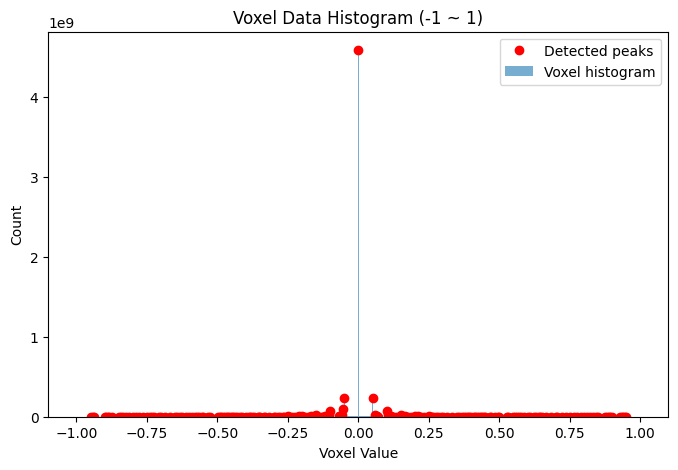

In [9]:
import os
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 데이터 경로 설정
data_path = '/workspace/data/GOPRO/test/'
h5_folder = sorted(os.listdir(data_path))

all_voxel = []

for h5_name in tqdm(h5_folder, ncols=80):
    h5_path = os.path.join(data_path, h5_name)
    
    # H5 파일 열기
    with h5py.File(h5_path, 'r') as f:
        # voxel 그룹에 어떤 key들이 있는지 확인
        voxel_keys = list(f['voxels'].keys())
        
        # 모든 voxel 데이터를 순회하면서 수집
        for k in voxel_keys:
            voxel_data = np.array(f['voxels'][k])
            max_val = np.max(np.abs(voxel_data))
            
            # 혹시 0으로 나누는 상황 방지
            if max_val != 0:
                voxel_data = voxel_data / max_val  # -1 ~ 1 범위로 정규화
            
            all_voxel.append(voxel_data)

            if k ==30:
                break   

print(f"총 수집된 voxel 배열 개수: {len(all_voxel)}")

# 1차원으로 펼치기
voxel_values = np.concatenate([v.flatten() for v in all_voxel])

# -1부터 1 범위를 200개 bin으로 나누어 히스토그램 계산
hist, bin_edges = np.histogram(voxel_values, bins=1000, range=(-1, 1))

# bin 중심값 계산 (시각화 및 분석 편의)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# 피크 찾기
peaks, properties = find_peaks(
    hist,
    prominence=25,  # 주변 대비 얼마나 두드러져야 피크로 볼지
    distance=1       # 피크 간 최소 거리(bin 단위)
)

peak_x = bin_centers[peaks]
peak_height = hist[peaks]

print("검출된 피크 위치 (x):", peak_x)
print("각 피크에서의 히스토그램 값 (y):", peak_height)

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist, width=(bin_edges[1]-bin_edges[0]),
        align='center', alpha=0.6, label='Voxel histogram')
plt.plot(peak_x, peak_height, 'ro', label='Detected peaks')
plt.title("Voxel Data Histogram (-1 ~ 1)")
plt.xlabel("Voxel Value")
plt.ylabel("Count")
plt.legend()
plt.show()



In [21]:
# 딕셔너리로 묶기: 각 peak_x 값에 대응하는 peak_height 값을 저장
peaks_dict = {float(px): int(ph) for px, ph in zip(peak_x, peak_height)}

for key,value in peaks_dict.items():
    print(key,value)


-0.9490000009536743 1758
-0.9409999847412109 114
-0.937000036239624 33
-0.8989999890327454 1746
-0.8949999809265137 655
-0.8889999985694885 324
-0.8830000162124634 128
-0.875 57
-0.8489999771118164 1874
-0.8429999947547913 720
-0.8330000042915344 298
-0.8230000138282776 116
-0.812999963760376 37
-0.7990000247955322 1563
-0.7890000343322754 807
-0.7770000100135803 281
-0.7649999856948853 129
-0.7490000128746033 1699
-0.7369999885559082 738
-0.7330000400543213 61
-0.7229999899864197 240
-0.7049999833106995 265
-0.6990000009536743 1664
-0.6850000023841858 849
-0.6669999957084656 747
-0.6489999890327454 1956
-0.6430000066757202 56
-0.6310000419616699 1347
-0.625 1060
-0.6110000014305115 1949
-0.5989999771118164 4276
-0.5889999866485596 2980
-0.5789999961853027 4396
-0.5709999799728394 204
-0.562999963760376 3555
-0.5550000071525574 6702
-0.5490000247955322 10511
-0.5329999923706055 2215
-0.5270000100135803 14978
-0.49900001287460327 68710
-0.4909999966621399 458
-0.4869999885559082 547
-0.

  0%|                                                     | 0/8 [00:00<?, ?it/s]

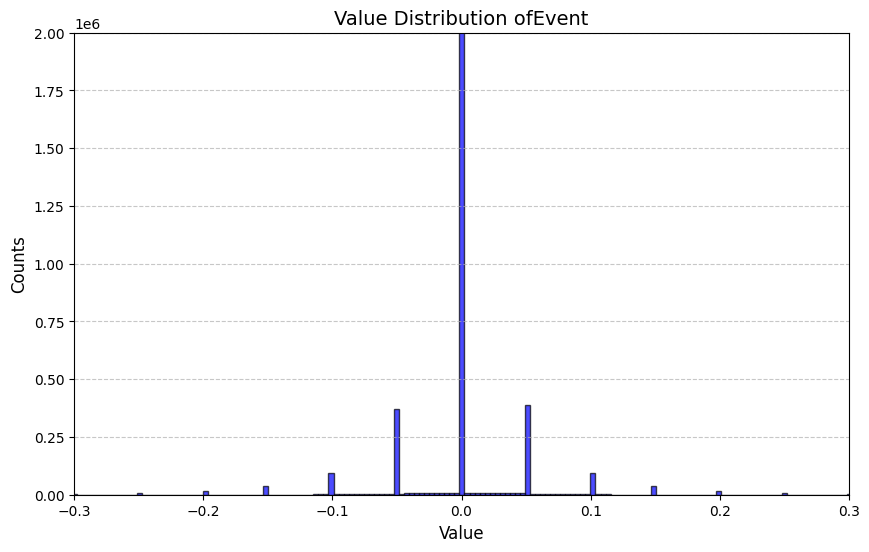

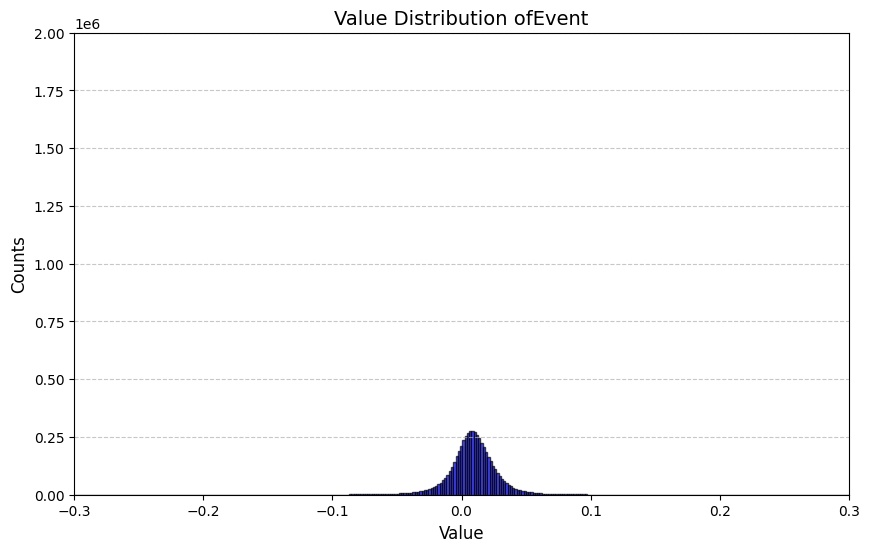

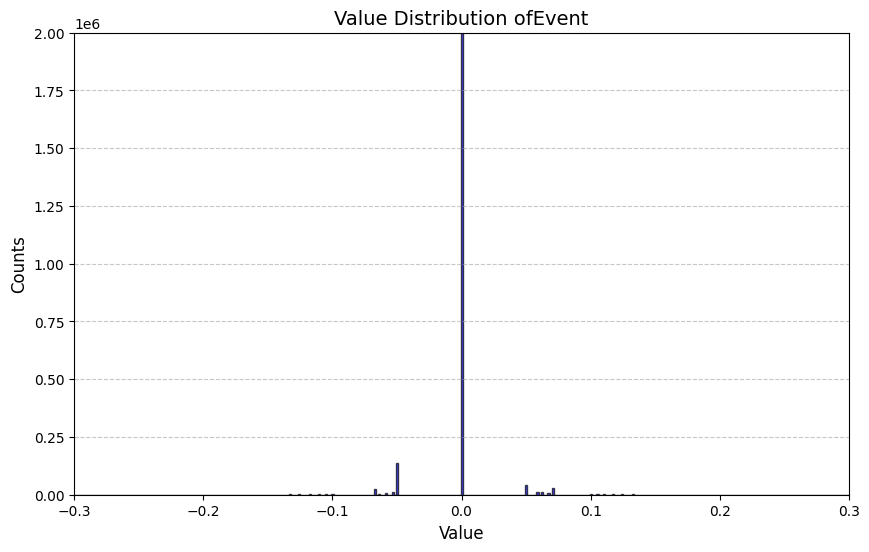

  0%|                                                     | 0/8 [00:01<?, ?it/s]

-1.0
-0.41175544
-0.411


In [18]:
import os
import h5py
import numpy as np
from tqdm import tqdm

# Data path
data_path = '/workspace/data/GOPRO/test/'
h5_folder = sorted(os.listdir(data_path))




# Iterate through H5 files
for h5 in tqdm(h5_folder[3:], ncols=80):
    imgs_path = os.path.join(data_path, h5)
    scene = h5[:-3]

    with h5py.File(imgs_path, 'r') as h5_file:
        refined_events = h5_file['gen_event_refined']
        voxels = h5_file['voxels']
        events = h5_file['gen_event']

        for i, event in enumerate(refined_events):
            # Load datasets
            refined_event = np.array(h5_file['gen_event_refined'][event])
            voxel = np.array(h5_file['voxels']['voxel{:09d}'.format(i)])
            event = np.array(h5_file['gen_event']['image{:09d}'.format(i)])

            max_val = np.max(np.abs(voxel))
            voxel = voxel/max_val


            voxel = voxel.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(voxel, bins=500, color='blue', alpha=0.7, edgecolor='black')
            plt.title(f"Value Distribution ofEvent", fontsize=14)
            plt.xlabel("Value", fontsize=12)
            plt.ylabel("Counts", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0, 2000000)
            
            # x축 범위를 -1에서 1로 설정
            plt.xlim(-0.3, 0.3)

            plt.show()

            # 히스토그램 그리기
            event = event.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(event, bins=500, color='blue', alpha=0.7, edgecolor='black')
            plt.title(f"Value Distribution ofEvent", fontsize=14)
            plt.xlabel("Value", fontsize=12)
            plt.ylabel("Counts", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0, 2000000)
            
            # x축 범위를 -1에서 1로 설정
            plt.xlim(-0.3, 0.3)

            plt.show()

            d_event = discretize_values_bidirectional(event,x_peak)
            d_event = d_event.flatten()
                # 히스토그램 그리기
            plt.figure(figsize=(10, 6))
            plt.hist(d_event, bins=500, color='blue', alpha=0.7, edgecolor='black')
            plt.title(f"Value Distribution ofEvent", fontsize=14)
            plt.xlabel("Value", fontsize=12)
            plt.ylabel("Counts", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0, 2000000)
            
            # x축 범위를 -1에서 1로 설정
            plt.xlim(-0.3, 0.3)

            plt.show()

            print(np.min(voxel))
            print(np.min(event))
            print(np.min(d_event))

            break

    break



# 데이터 범위 확인

In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm

# Data path
data_path = '/workspace/data/GOPRO/test/'
h5_folder = sorted(os.listdir(data_path))

output_mother_path = '/workspace/data/FFTformer/results/Gopro_test/visualization'

# Initialize min/max values for each dataset
min_refined, max_refined = float('inf'), float('-inf')
min_voxel, max_voxel = float('inf'), float('-inf')
min_event, max_event = float('inf'), float('-inf')
min_another_event, max_another_event = float('inf'), float('-inf')

# Iterate through H5 files
for h5 in tqdm(h5_folder, ncols=80):
    imgs_path = os.path.join(data_path, h5)
    scene = h5[:-3]
    scene_folder = os.listdir(os.path.join(output_mother_path,scene))
    scene_folder.sort()
    
    with h5py.File(imgs_path, 'r') as h5_file:
        refined_events = h5_file['gen_event_refined']
        voxels = h5_file['voxels']
        events = h5_file['gen_event']

        for i, event in enumerate(refined_events):
            # Load datasets
            refined_event = np.array(h5_file['gen_event_refined'][event])
            voxel = np.array(h5_file['voxels']['voxel{:09d}'.format(i)])
            event = np.array(h5_file['gen_event']['image{:09d}'.format(i)])
            another_event = np.load(os.path.join(output_mother_path,scene,scene_folder[i],'out.npy'))

            # Update min/max values for each dataset
            min_refined = min(min_refined, refined_event.min())
            max_refined = max(max_refined, refined_event.max())

            min_voxel = min(min_voxel, voxel.min())
            max_voxel = max(max_voxel, voxel.max())

            min_event = min(min_event, event.min())
            max_event = max(max_event, event.max())

            min_another_event = min(min_another_event, another_event.min())
            max_another_event = max(max_another_event, another_event.max())

# Print results
print("\nData Range Summary:")
print(f"Refined Event - Min: {min_refined}, Max: {max_refined}")
print(f"Voxel - Min: {min_voxel}, Max: {max_voxel}")
print(f"Event - Min: {min_event}, Max: {max_event}")
print(f"Another Event - Min: {min_another_event}, Max: {max_another_event}")

# Count zeros

In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm

# Data path
data_path = '/workspace/data/GOPRO/test/'
h5_folder = sorted(os.listdir(data_path))

output_mother_path = '/workspace/data/FFTformer/results/Gopro_test/visualization'

# Initialize counters for zero values
total_pixels_refined = 0
total_pixels_voxel = 0
total_pixels_event = 0
total_pixels_another_event = 0

zero_count_refined = 0
zero_count_voxel = 0
zero_count_event = 0
zero_count_another_event = 0

# Iterate through H5 files
for h5 in tqdm(h5_folder, ncols=80):
    imgs_path = os.path.join(data_path, h5)
    scene = h5[:-3]
    scene_folder = os.listdir(os.path.join(output_mother_path,scene))
    scene_folder.sort()
    
    with h5py.File(imgs_path, 'r') as h5_file:
        refined_events = h5_file['gen_event_refined']
        voxels = h5_file['voxels']
        events = h5_file['gen_event']

        for i, event in enumerate(refined_events):
            # Load datasets
            refined_event = h5_file['gen_event_refined'][event][:]
            voxel = h5_file['voxels']['voxel{:09d}'.format(i)][:]
            event = h5_file['gen_event']['image{:09d}'.format(i)][:]
            another_event = np.load(os.path.join(output_mother_path,scene,scene_folder[i],'out.npy'))

            # Normalize voxel data
            max_val = np.max(np.abs(voxel))
            if max_val != 0:
                voxel = voxel / max_val

            # Count zeros in each dataset separately
            zero_count_refined += np.sum(refined_event == 0)
            zero_count_voxel += np.sum(voxel == 0)
            zero_count_event += np.sum(event == 0)
            zero_count_another_event += np.sum(another_event == 0)

            # Count total pixels separately
            total_pixels_refined += refined_event.size
            total_pixels_voxel += voxel.size
            total_pixels_event += event.size
            total_pixels_another_event += another_event.size

# Compute and print the zero ratio for each dataset
zero_ratio_refined = zero_count_refined / total_pixels_refined if total_pixels_refined > 0 else 0
zero_ratio_voxel = zero_count_voxel / total_pixels_voxel if total_pixels_voxel > 0 else 0
zero_ratio_event = zero_count_event / total_pixels_event if total_pixels_event > 0 else 0
zero_ratio_another_event = zero_count_another_event / total_pixels_another_event if total_pixels_another_event > 0 else 0

print("\nZero Ratio Summary:")
print(f"Total Pixels (Refined Event): {total_pixels_refined}")
print(f"Total Zero Count (Refined Event): {zero_count_refined}")
print(f"Average Zero Ratio (Refined Event): {zero_ratio_refined:.6f}\n")

print(f"Total Pixels (Voxel): {total_pixels_voxel}")
print(f"Total Zero Count (Voxel): {zero_count_voxel}")
print(f"Average Zero Ratio (Voxel): {zero_ratio_voxel:.6f}\n")

print(f"Total Pixels (Event): {total_pixels_event}")
print(f"Total Zero Count (Event): {zero_count_event}")
print(f"Average Zero Ratio (Event): {zero_ratio_event:.6f}\n")


print(f"Total Pixels (Event): {total_pixels_another_event}")
print(f"Total Zero Count (Event): {zero_count_another_event}")
print(f"Average Zero Ratio (Event): {zero_ratio_another_event:.6f}")

# Histograms

In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_path = '/workspace/data/GOPRO/test/'
h5_folder = sorted(os.listdir(data_path))
output_mother_path = '/workspace/data/FFTformer/results/Gopro_test/visualization'

# 전체 데이터셋의 각 타입을 저장할 리스트 초기화 (각 리스트의 각 원소는 한 샘플의 배열)
all_voxel = []
all_event = []
all_refined_event = []
all_another_event = []

# 모든 H5 파일 순회 (예시로 각 파일에서 최대 2개의 샘플만 수집)
for h5_name in tqdm(h5_folder, ncols=80):
    imgs_path = os.path.join(data_path, h5_name)
    scene = h5_name[:-3]  # 예: ".h5" 제거
    scene_dir = os.path.join(output_mother_path, scene)
    if not os.path.exists(scene_dir):
        continue
    scene_folder = sorted(os.listdir(scene_dir))
    
    with h5py.File(imgs_path, 'r') as h5_file:
        refined_events = h5_file['gen_event_refined']
        for i, event_key in enumerate(refined_events):
            try:
                voxel_data = np.array(h5_file['voxels'][f'voxel{i:09d}'])
                max_val = np.max(np.abs(voxel_data))
                voxel_data = voxel_data / max_val
                
                event_data = np.array(h5_file['gen_event'][f'image{i:09d}'])
                refined_event = np.array(h5_file['gen_event_refined'][f'image{i:09d}'])
                another_event_path = os.path.join(scene_dir, scene_folder[i], 'out.npy')
                another_event_data = np.load(another_event_path)
            except Exception as e:
                print(f"Error in file {h5_name} sample {i}: {e}")
                continue
            
            all_voxel.append(voxel_data)
            all_event.append(event_data)
            all_refined_event.append(refined_event)
            all_another_event.append(another_event_data)
            if i == 30:
                break

# 함수: 각 샘플의 raw 히스토그램 계산
def compute_histogram(data, bins=100, val_range=(-1, 1)):
    hist, bin_edges = np.histogram(data.flatten(), bins=bins, range=val_range)
    return hist, bin_edges

# 함수: 리스트에 있는 모든 배열에 대해 평균 히스토그램 계산
# (각 샘플의 히스토그램을 합산한 후 샘플 수로 나누고, 최종적으로 정규화)
def average_histogram_raw(array_list, bins=100, val_range=(-1, 1)):
    hist_sum = None
    for arr in array_list:
        hist, bin_edges = compute_histogram(arr, bins=bins, val_range=val_range)
        if hist_sum is None:
            hist_sum = hist
        else:
            hist_sum += hist
    hist_avg = hist_sum / len(array_list)
    # 정규화: 전체 합이 1이 되도록
    # hist_avg = hist_avg.astype(float)
    # hist_avg = hist_avg / (hist_avg.sum() + 1e-8)
    return hist_avg, bin_edges

# 각 데이터셋에 대해 평균 히스토그램 계산 (범위: -1 ~ 1)
hist_voxel, bin_edges = average_histogram_raw(all_voxel, bins=300, val_range=(-1, 1))
hist_event, _ = average_histogram_raw(all_event, bins=300, val_range=(-1, 1))
hist_another, _ = average_histogram_raw(all_another_event, bins=300, val_range=(-1, 1))
hist_refined, _ = average_histogram_raw(all_refined_event, bins=300, val_range=(-1, 1))

# x 좌표: bin centers 계산
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# GT (voxel) 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_voxel, width=bin_width, label='GT (voxel)', color='blue', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of GT Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 1)
plt.show()

# Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_event, width=bin_width, label='Event', color='green', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of SDv2 Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 1)
plt.show()

# Another Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_another, width=bin_width, label='KL Event', color='red', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of KL Refined Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 1)
plt.show()

# Refined Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_refined, width=bin_width, label='Refined Event', color='black', alpha=0.7, edgecolor='black')
plt.title("Average  Histogram of L2 Refined Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 1)
plt.show()


In [ ]:
# GT (voxel) 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_voxel, width=bin_width, label='GT (voxel)', color='blue', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of GT Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.2, 0.2)
plt.show()

# Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_event, width=bin_width, label='Event', color='green', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of SDv2 Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.2, 0.2)
plt.show()

# Another Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_another, width=bin_width, label='KL Event', color='red', alpha=0.7, edgecolor='black')
plt.title("Average Histogram of KL:L1=1:0.1 Refined Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.2, 0.2)
plt.show()

# Refined Event 히스토그램을 막대 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist_refined, width=bin_width, label='Refined Event', color='black', alpha=0.7, edgecolor='black')
plt.title("Average  Histogram of L2 Refined Event", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-0.2, 0.2)
plt.show()

  0%|                                                    | 0/19 [00:00<?, ?it/s]

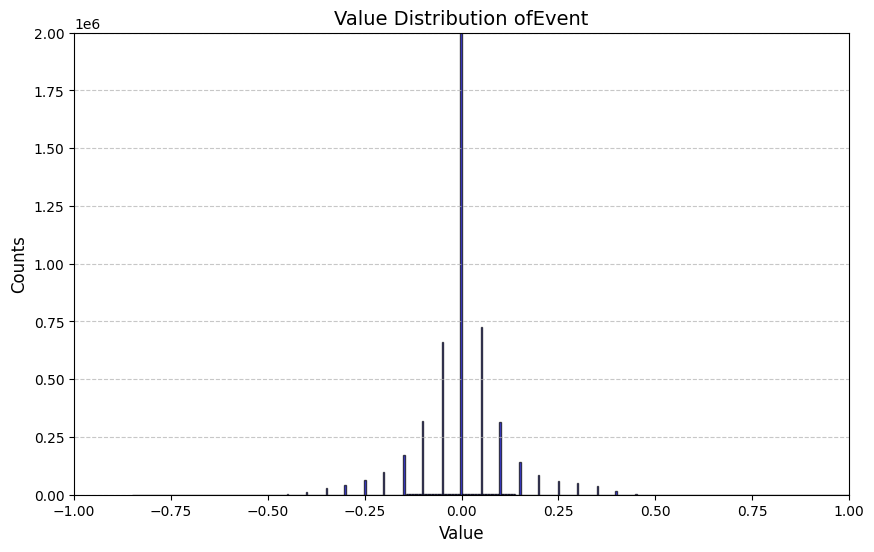

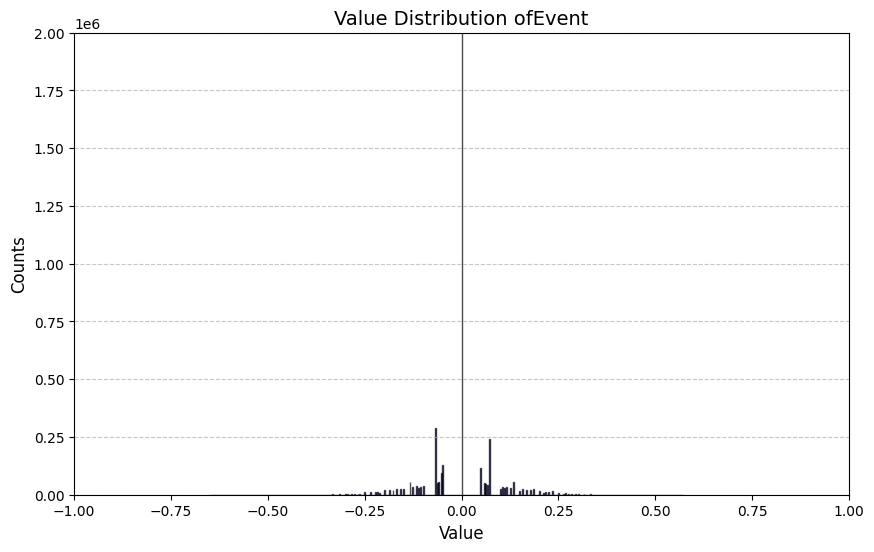

  0%|                                                    | 0/19 [00:00<?, ?it/s]


In [4]:
import os
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Data path
data_path = '/workspace/data/GOPRO/train/'
h5_folder = sorted(os.listdir(data_path))




# Iterate through H5 files
for h5 in tqdm(h5_folder[3:], ncols=80):
    imgs_path = os.path.join(data_path, h5)
    scene = h5[:-3]

    with h5py.File(imgs_path, 'r') as h5_file:
        refined_events = h5_file['gen_event_refined']
        voxels = h5_file['voxels']
        events = h5_file['gen_event']

        for i, event in enumerate(refined_events):
            # Load datasets
            refined_event = np.array(h5_file['gen_event_refined'][event])
            voxel = np.array(h5_file['voxels']['voxel{:09d}'.format(i)])
            event = np.array(h5_file['gen_event_discrete']['image{:09d}'.format(i)])

            max_val = np.max(np.abs(voxel))
            voxel = voxel/max_val


            voxel = voxel.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(voxel, bins=500, color='blue', alpha=0.7, edgecolor='black')
            plt.title(f"Value Distribution ofEvent", fontsize=14)
            plt.xlabel("Value", fontsize=12)
            plt.ylabel("Counts", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0, 2000000)
            
            # x축 범위를 -1에서 1로 설정
            plt.xlim(-1, 1)

            plt.show()

            # 히스토그램 그리기
            event = event.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(event, bins=500, color='blue', alpha=0.7, edgecolor='black')
            plt.title(f"Value Distribution ofEvent", fontsize=14)
            plt.xlabel("Value", fontsize=12)
            plt.ylabel("Counts", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0, 2000000)
            
            # x축 범위를 -1에서 1로 설정
            plt.xlim(-1, 1)

            plt.show()


            break

    break

